# __InterUni Datathon - Fraud Dectection Analysis__
---
---

**Team 5/12 - Macquarie University**

- Team Member 1: `Chau Anh Cong`
- Team Member 2: ``
- Team Member 3: ``
- Team Member 4: ``
- Team Member 5: ``
---

## Data Importing & First Look

In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt

train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')

print(train_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10966 entries, 0 to 10965
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   TransactionNumber    10966 non-null  int64  
 1   UserID               10966 non-null  int64  
 2   Age                  10966 non-null  int64  
 3   Gender               10966 non-null  object 
 4   Occupation           10966 non-null  object 
 5   EducationLevel       10966 non-null  object 
 6   MaritalStatus        10966 non-null  object 
 7   NumDependents        10966 non-null  int64  
 8   Income               10966 non-null  object 
 9   Expenditure          10966 non-null  object 
 10  GiftsTransaction     10966 non-null  object 
 11  TransactionDate      10966 non-null  object 
 12  TransactionTime      10966 non-null  object 
 13  TransactionAmount    10966 non-null  object 
 14  MerchantID           10966 non-null  object 
 15  TransactionType      10966 non-null 

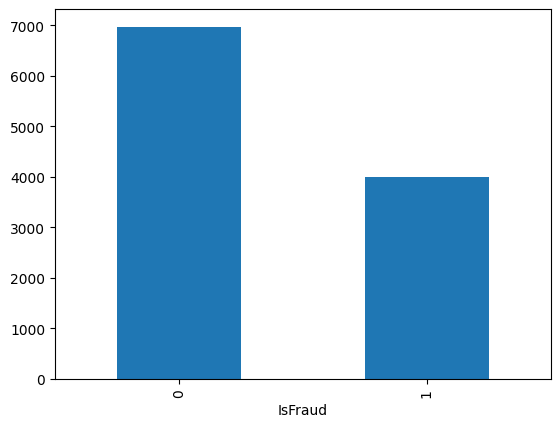

In [2]:
# plot label distribution
train_data['IsFraud'].value_counts().plot(kind='bar')
plt.show()

## Data Preprocessing

In [3]:
gender_mapping = {
    'fem': 'Female',
    'Female': 'Female',
    'she': 'Female',
    'woman': 'Female',
    'he': 'Male',
    'man': 'Male',
    'Male': 'Male',
    'isnotfemale': 'Male',
    'isnotmale': 'Female',
}


location_mapping = {
    'Adelaide': 'Adelaide',
    'adl': 'Adelaide',
    'Adelaide City': 'Adelaide',
    'Adl': 'Adelaide',
    'Bne': 'Brisbane',
    'BNE': 'Brisbane',
    'brisbane': 'Brisbane',
    'Brisbane': 'Brisbane',
    'canberra': 'Canberra',
    'Canberra': 'Canberra',
    'CBR': 'Canberra',
    'Cbr': 'Canberra',
    'c': 'Canberra',
    'darwin': 'Darwin',
    'Darwin': 'Darwin',
    'Drw': 'Darwin',
    'DRW': 'Darwin',
    'Hbt': 'Hobart',
    'HBT': 'Hobart',
    'hobart': 'Hobart',
    'Hobart': 'Hobart',
    'Mel': 'Melbourne',
    'melb': 'Melbourne',
    'Melb': 'Melbourne',
    'melbourne': 'Melbourne',
    'Melbourne': 'Melbourne',
    'Melburne': 'Melbourne',
    'Melburn': 'Melbourne',
    'MLB': 'Melbourne',
    'perth': 'Perth',
    'Perth': 'Perth',
    'PTH': 'Perth',
    'Pth': 'Perth',
    'Syd': 'Sydney',
    'Sydney': 'Sydney',
    'SYD': 'Sydney',
    'sydney': 'Sydney'
}


mobile_mapping = {
    'android': 'Mobile',
    'galaxys7': 'Mobile',
    'iphone 15': 'Mobile',
    'mob': 'Mobile',
    'smartphone': 'Mobile',
    'Mobile': 'Mobile',
}

In [4]:
def age_correction(age):
    if age < 0:
        age = abs(age)
    if age % 1000 == 0:
        age = age/1000

    return age


def standard_time(time_str):
    try:
        if 'AM' in time_str or 'PM' in time_str:
            return pd.to_datetime(time_str, format='%I:%M:%S %p').strftime('%H:%M:%S')
        
        return pd.to_datetime(time_str, format='%H:%M:%S').strftime('%H:%M:%S')
    
    except (ValueError, TypeError):
        try:
            parts = time_str.split('/')
            corrected_time = f'{parts[0]}:{parts[1]}:{parts[2]}'
            return pd.to_datetime(corrected_time, format='%H:%M:%S').strftime('%H:%M:%S')
        except Exception:
            return None


def categorize_time(hour):
    if 0 <= hour < 6:
        return 'Night'
    elif 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    else:
        return 'Evening'
    

def get_currency_and_symbol(val):
    if 'AUD' in val or 'AU' in val:
        # create a feature for aud
        return re.sub(r'[^\d.]', '', val), 'AUD' 
    elif 'AED' in val:
        value = re.sub(r'[^\d.]', '', val)
        # convert AED to AUD
        return float(value) * 0.35, 'AED'
    elif '£' in val:
        value = re.sub(r'[^\d.]', '', val)
        # convert pounds to AUD
        return float(value) * 1.8, 'GBP'
    elif 'GBP' in val:
        value = re.sub(r'[^\d.]', '', val)
        # convert pounds to AUD
        return float(value) * 1.8, 'GBP'
    else:
        return "Unidentified", "Unknown"


In [5]:
def Cleaning(df):
    
    df['Age'] = df['Age'].apply(age_correction)


    df['TransactionTime'] = df['TransactionTime'].apply(standard_time)
    df.dropna(subset=['TransactionTime'], inplace=True)
    df['TransactionTime'] = pd.to_datetime(df['TransactionTime'], format='%H:%M:%S').dt.hour
    df['TransactionTime'] = df['TransactionTime'].apply(categorize_time)


    df['TransactionDate'] = pd.to_datetime(df['TransactionDate'], format='%Y-%m-%d')
    df['Date'] = df['TransactionDate'].dt.day   
    df['Month'] = df['TransactionDate'].dt.month  
    df['Weekday'] = df['TransactionDate'].dt.day_name()


    df['Income'], df['Income_Currency'] = zip(*df['Income'].apply(get_currency_and_symbol))
    df['Income'] = pd.to_numeric(df['Income'], errors='coerce')  


    df['Expenditure'], df['Expenditure_Currency'] = zip(*df['Expenditure'].apply(get_currency_and_symbol))
    df['Expenditure'] = pd.to_numeric(df['Expenditure'], errors='coerce')

    df['GiftsTransaction'], df['GiftsTransaction_Currency'] = zip(*df['GiftsTransaction'].apply(get_currency_and_symbol))
    df['GiftsTransaction'] = pd.to_numeric(df['GiftsTransaction'], errors='coerce')

    df['TransactionAmount'], df['TransactionAmount_Currency'] = zip(*df['TransactionAmount'].apply(get_currency_and_symbol))
    df['TransactionAmount'] = pd.to_numeric(df['TransactionAmount'], errors='coerce') 


    # Keep only the domain after @ for EmailDomain
    df['EmailDomain'] = df['EmailDomain'].apply(lambda x: x.split('@')[1])


    df['Gender'] = df['Gender'].map(gender_mapping).fillna('Other')
    df['TransactionLocation'] = df['TransactionLocation'].replace(location_mapping)
    df['DeviceType'] = df['DeviceType'].replace(mobile_mapping)
    
    return df

In [6]:
def binary_encode(df, column, positive_value):
    df = df.copy()
    df[column] = df[column].apply(lambda x: 1 if x == positive_value else 0)
    return df

def ordinal_encode(df, column, ordering):
    df = df.copy()
    df[column] = df[column].apply(lambda x: ordering.index(x))
    return df

nominal_columns = ["Weekday", "MaritalStatus", "TransactionType", "TransactionLocation", "Income_Currency", "Expenditure_Currency", 
                    "GiftsTransaction_Currency", "TransactionAmount_Currency", "TransactionTime","DeviceType", "MerchantID", "EmailDomain"]

occupation_order = [
    "Student",
    "Unemployed",
   "Retired", 
    "Professional",
]

education_order = [
    "High School","Bachelor","Master","PhD"
]


def Encoding(df, drop_id=True):
    df = binary_encode(df, "Gender", "Male")
    df = ordinal_encode(df, "Occupation", occupation_order)
    df = ordinal_encode(df, "EducationLevel", education_order)
    df = binary_encode(df, "Terrorism", True)

    # One hot encoding for the rest
    df = pd.get_dummies(df, columns=nominal_columns, prefix=nominal_columns, dtype=int)

    # Keep only relevant columns after cleaning
    if drop_id:
        columns_to_drop = ["TransactionNumber", "UserID", "TransactionDate"]
    else:
        columns_to_drop = ["UserID", "TransactionDate"]
    
    df = df.drop(columns=columns_to_drop)
    
    return df
    

In [7]:
def PreProcess(df, drop_id=True):
    df_cleaned = Cleaning(df)
    df_encoded = Encoding(df_cleaned, drop_id)
    return df_encoded

train_df_cleaned = PreProcess(train_data)
test_df_cleaned = PreProcess(test_data, drop_id=False)

In [8]:
train_df_cleaned

,Age,Gender,Occupation,EducationLevel,NumDependents,Income,Expenditure,GiftsTransaction,TransactionAmount,Latitude,...,MerchantID_M005,MerchantID_M006,MerchantID_M007,MerchantID_M008,EmailDomain_disposable.com,EmailDomain_gmail.com,EmailDomain_outlook.com,EmailDomain_securemail.com,EmailDomain_tempmail.com,EmailDomain_yahoo.com
0,37.0,0,3,1,3,28884.43,14610.610,1890.018,258.1400,-31.840233,...,0,1,0,0,1,0,0,0,0,0
1,34.0,1,0,0,4,54919.07,39169.490,8945.478,34.9400,-37.020100,...,0,0,0,0,0,1,0,0,0,0
2,25.0,1,1,2,2,74728.57,55873.760,2069.730,323.8200,-31.840233,...,0,0,0,1,0,1,0,0,0,0
3,25.0,1,3,0,3,55712.62,31377.164,4335.700,11.3715,-37.020100,...,0,0,0,0,0,0,0,0,1,0
4,38.0,1,3,0,4,53004.70,15260.357,4763.480,399.2625,-37.020100,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10961,25.0,1,1,0,3,64488.68,21813.530,4940.154,182.5100,-37.020100,...,0,0,1,0,0,0,1,0,0,0
10962,18.0,0,3,0,2,80403.31,63429.080,344.178,137.5000,-37.020100,...,0,0,0,0,0,0,0,0,0,1
10963,22.0,1,1,0,3,29048.42,18806.310,91.854,112.3700,-31.840233,...,0,0,0,0,0,0,0,0,0,1
10964,29.0,0,0,0,4,28654.66,9748.530,2122.938,68.0500,-37.020100,...,0,0,0,0,1,0,0,0,0,0


In [9]:
test_df_cleaned

,TransactionNumber,Age,Gender,Occupation,EducationLevel,NumDependents,Income,Expenditure,GiftsTransaction,TransactionAmount,...,MerchantID_M005,MerchantID_M006,MerchantID_M007,MerchantID_M008,EmailDomain_disposable.com,EmailDomain_gmail.com,EmailDomain_outlook.com,EmailDomain_securemail.com,EmailDomain_tempmail.com,EmailDomain_yahoo.com
0,11854,35.0,1,0,1,4,53733.41,29296.02,4867.362,225.64,...,1,0,0,0,0,0,1,0,0,0
1,2647,23.0,1,3,2,2,54856.77,34628.31,1727.928,658.10,...,0,0,0,0,0,1,0,0,0,0
2,5945,44.0,1,0,1,2,59011.72,33312.46,3535.560,133.59,...,0,0,0,0,0,0,0,0,0,1
3,6798,40.0,1,0,0,3,128795.40,67049.00,17129.124,6.74,...,0,0,0,1,0,1,0,0,0,0
4,12985,18.0,1,3,1,3,44506.03,22856.31,3127.950,15.67,...,0,0,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7307,2636,40.0,0,0,0,4,46099.15,23638.96,5907.204,370.89,...,0,0,1,0,0,1,0,0,0,0
7308,14557,52.0,1,1,2,0,148540.21,76153.21,3756.672,48.35,...,0,0,0,1,0,0,0,0,0,1
7309,296,42.0,1,0,1,3,62223.32,25581.85,4818.384,110.23,...,0,1,0,0,0,1,0,0,0,0
7310,1864,39.0,0,0,3,0,119426.16,85940.02,8506.422,202.37,...,0,0,0,1,0,1,0,0,0,0


## Exploratory Data Analysis

## Predictive Analytics

### Data Re-sampling

explain what we did here

In [10]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(sampling_strategy='majority')
X_rus, y_rus = rus.fit_resample(train_data.drop(columns=['IsFraud']), train_data['IsFraud'])

train_df = pd.concat([X_rus, y_rus], axis=1)
train_df.reset_index(drop=True, inplace=True)

### Modelling

In [11]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import f1_score

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [12]:
y = train_df_cleaned['IsFraud']
X = train_df_cleaned.drop('IsFraud', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Random Forest Classifier

In [13]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20, 30],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 10],
    'bootstrap': [True]
}

# Initialize the Random Forest Classifier
rf = RandomForestClassifier(random_state=42)

# Initialize the RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, 
                                scoring="f1", cv=10, refit=True, random_state=42, n_jobs=-1)

# Fit the model
random_search.fit(X_train, y_train)

# Get the best parameters
rf_best = random_search.best_estimator_

# Make predictions
rf_y_pred = rf_best.predict(X_test)

rf_f1 = f1_score(y_test, rf_y_pred)
print(f"Random Forest F1 Score: {rf_f1}")

d:\Anaconda\envs\interuni-datathon\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Random Forest F1 Score: 0.9969641772920461


### XGBoost Classifier

In [14]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'max_depth': [3, 5, 7, 10]
}

# Initialize the XGBoost Regressor
xg_classifier = XGBClassifier(random_state=42)

# Initialize the RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=xg_classifier, param_distributions=param_grid, 
                                    cv=5, scoring="f1", refit=True, random_state=42, n_jobs=-1)

# Fit the model
random_search.fit(X_train, y_train)

# Get the best parameters
xgb_best = random_search.best_estimator_

# Make predictions
xgb_y_pred = xgb_best.predict(X_test)

xgb_f1 = f1_score(y_test, xgb_y_pred)
print(f"XGBoost F1 Score: {xgb_f1}")

XGBoost F1 Score: 0.9987878787878788
